In [177]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [178]:
"""UC Berkeley Data Science Example Common Ultility functions"""


def head(filename, lines=5):
    """
    Returns the first few lines of a file.
    
    filename: the name of the file to open
    lines: the number of lines to include
    
    return: A list of the first few lines from the file.
    """
    from itertools import islice
    with open(filename, "r") as f:
        return list(islice(f, lines))
    

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.
    
    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded
    
    return: The pathlib.Path object representing the file.
    """

    import requests
    from hashlib import md5
    from pathlib import Path
    
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    file_path = data_dir/Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        resp = requests.get(data_url, stream=True)
        file_size = int(resp.headers.get('content-length', 0))
        step = 40
        chunk_size = file_size//step
        with file_path.open('wb') as f:
            for chunk in resp.iter_content(chunk_size): # write file in chunks
                f.write(chunk)
                step -= 1
                print('[' + '#'*(41 - step) + (step)*' ' + ']\r', end='')
        print(f"\nDownloaded {data_url.split('/')[-1]}!")
    else:
        import time
        time_downloaded = time.ctime(file_path.stat().st_ctime)
        print("Using version already downloaded:", time_downloaded)
    # Compute and print md5 hash of file, whether newly downloaded or not
    m5 = md5()
    m5.update(file_path.read_bytes())
    print(f"MD5 hash of file: {m5.hexdigest()}")
    return file_path


def line_count(file):
    """
    Computes the number of lines in a file.
    
    file: the file in which to count the lines.
    return: The number of lines in the file
    """
    with open(file, "r") as f:
        return sum(1 for line in f)



def fetch_and_cache_gdrive(gdrive_id, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.
    
    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded
    
    return: The pathlib.Path object representing the file.
    """

    import requests
    from hashlib import md5
    from pathlib import Path
    
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    file_path = data_dir/Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        download_file_from_google_drive(gdrive_id, file_path)
    else:
        import time
        time_downloaded = time.ctime(file_path.stat().st_ctime)
        print("Using version already downloaded:", time_downloaded)
    # Compute and print md5 hash of file, whether newly downloaded or not
    m5 = md5()
    m5.update(file_path.read_bytes())
    print(f"MD5 hash of file: {m5.hexdigest()}")
    return file_path

    
def download_file_from_google_drive(id, destination):
    import requests
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        print("Downloading...")
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [179]:

fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Thu May 30 22:07:28 2019
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Thu May 30 22:07:30 2019
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [180]:
print(original_training_data.isna().any())

original_training_data = original_training_data.fillna('')

print(original_training_data.isna().any())

id         False
subject     True
email      False
spam       False
dtype: bool
id         False
subject    False
email      False
spam       False
dtype: bool


In [181]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



The spam emails have the <html> at the end of the email, which is usual with spams emails but unusual with regular emails. We can use this to identify spam emails. 

In [182]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

In [183]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = (np.array([texts.str.contains(i) for i in words]).T).astype(int)
    return indicator_array

In [184]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


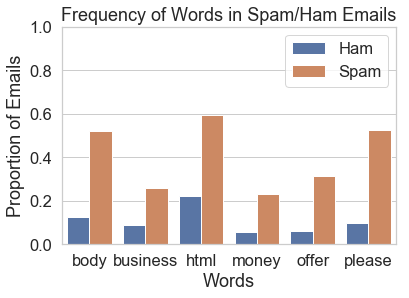

In [185]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

words = ['body', 'business', 'html', 'money', 'offer', 'please']

new_train = words_in_texts(words, train['email'])

new_df = pd.DataFrame(data=new_train, columns=words)
new_df['type'] = train['spam']

plt.figure()
plt.figsize=(8,6)

sns.barplot(x = 'variable', y = 'value', hue = 'type',
            data = (new_df.replace({'type':{0 : 'Ham',1 : 'Spam'}})
                    .melt('type').groupby(['type', 'variable'])
                    .mean().reset_index()))
plt.ylim([0, 1])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')

plt.title("Frequency of Words in Spam/Ham Emails")
plt.legend();

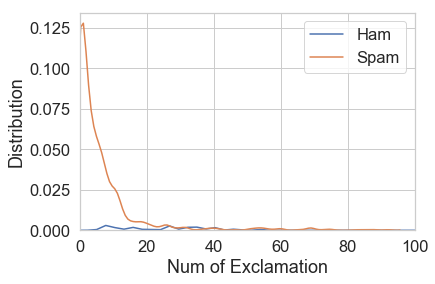

In [186]:

def find_exclamation(data):
    data['num exclamation'] = data['email'].str.findall('!').str.len()
    return data
find_exclamation(train_copy)
a = [0,1]
for i in a:
    subset = train_copy[train_copy['spam'] == i]
    if i == 0:
        sns.distplot(subset['num exclamation'], hist = False, label = 'Ham')
    else:
        sns.distplot(subset['num exclamation'], hist = False, label = 'Spam')
plt.xlim(0, 100)
plt.xlabel('Num of Exclamation')
plt.ylabel('Distribution')
plt.legend()
plt.show()

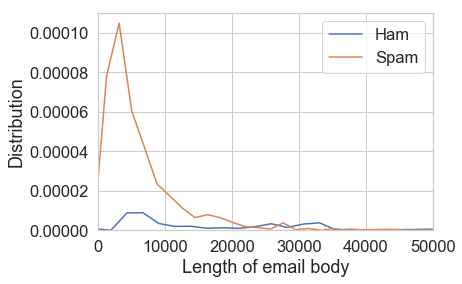

In [187]:
train_copy = train.copy()
train_copy['length'] = train_copy['email'].str.len()

p1 = sns.distplot(train_copy.loc[train_copy['spam'] == 0, 'length'], hist=False, label='Ham')
p2 = sns.distplot(train_copy.loc[train_copy['spam'] == 1, 'length'], hist=False, label='Spam')

plt.xlabel('Length of email body')
plt.ylabel('Distribution')
plt.xlim((0, 50000))

plt.legend()
plt.show();

/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


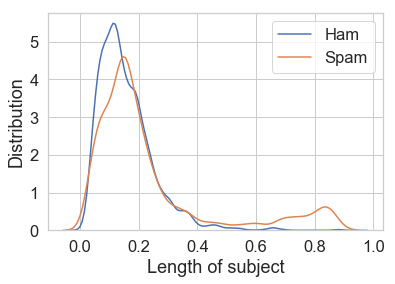

In [188]:
def find_capital_letter_in_subject(data):
    data['proportion_low_sub'] = data['subject'].str.findall(r'[A-Z]').str.len() / data['subject'].str.findall(r'[a-zA-Z]').str.len()
    return data
find_capital_letter_in_subject(train_copy)
a = [0,1]
for i in a:
    subset = train_copy[train_copy['spam'] == i]
    if i == 0:
        sns.distplot(subset['proportion_low_sub'], hist = False, label = 'Ham'
)
    else:
        sns.distplot(subset['proportion_low_sub'], hist = False, label = 'Spam')
#plt.xlim(0, 1000)
plt.xlabel('Length of subject')
plt.ylabel('Distribution')
plt.legend()
plt.show()

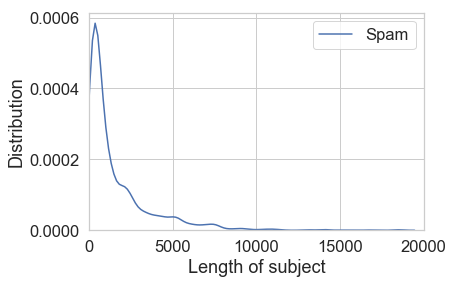

In [189]:
def number_of_punctuations(data):
    data['num punc'] = data['email'].str.findall('[^A-Za-z0-9]').str.len()
    return data
number_of_punctuations(train_copy)
a = [0,1]
for i in a:
     subset = train_copy[train_copy['spam'] == i]
if i == 0:
     sns.distplot(subset['num punc'], hist = False, label = 'Ham')
else:
     sns.distplot(subset['num punc'], hist = False, label = 'Spam')
plt.xlim(0, 20000)
plt.xlabel('Length of subject')
plt.ylabel('Distribution')
plt.legend()
plt.show()

/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


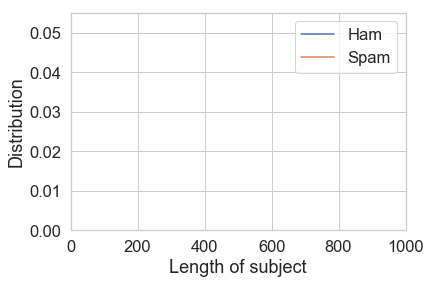

In [190]:
def capital_letter_ratio(data):


    data['proportion_low'] = data['email'].str.findall('[A-Z]').str.len() / data['email'].str.findall('[a-zA-Z]').str.len()
    return data

capital_letter_ratio(train_copy)
a = [0,1]
for i in a:
    subset = train_copy[train_copy['spam'] == i]
    if i == 0:
        sns.distplot(subset['proportion_low'], hist = False, label = 'Ham')
    else:
        sns.distplot(subset['proportion_low'], hist = False, label = 'Spam')
plt.xlim(0, 1000)
plt.xlabel('Length of subject')
plt.ylabel('Distribution')
plt.legend()
plt.show();

In [191]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), array([0, 0, 0, 0, 0]))

In [192]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy);

Training Accuracy:  0.7576201251164648


/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [193]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [194]:
zero_predictor_acc = np.mean(Y_train == 0)
zero_predictor_recall = 0

print(zero_predictor_acc, zero_predictor_recall)

0.7447091707706642 0


In [195]:
Y_train_pred = model.predict(X_train)

TP = np.count_nonzero((Y_train_pred == 1) & (Y_train_pred == Y_train))
TN = np.count_nonzero((Y_train_pred == 0) & (Y_train_pred == Y_train))
FP = np.count_nonzero((Y_train_pred == 1) & (Y_train_pred != Y_train))
FN = np.count_nonzero((Y_train_pred == 0) & (Y_train_pred != Y_train))

logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_far = FP / (FP + TN)
accuracy = (TP + TN) / len(Y_train_pred)

print('Precision:', logistic_predictor_precision,'recall:',logistic_predictor_recall,'far:', logistic_predictor_far, 'accuracy:', accuracy)

Precision: 0.6422287390029325 recall: 0.11418143899895725 far: 0.021805183199285077 accuracy: 0.7576201251164648


Attempt to improve accuracy by classifying the words that appear most in the emails since spams emails tend to have different pattern of words compare to regular personal emails. 

In [196]:
import re
from collections import Counter 
a = pd.Series(' '.join(original_training_data[original_training_data['spam'] == 1]['email']).lower().split())
b = [w for w in list(a) if re.search(r"\w+", w)]
d = Counter(b)

sorted_d = sorted(d.items(), key=lambda x: x[1], reverse=True)
l =[]
for i in range(len(sorted_d)):
    l.append(sorted_d[i][0])
l[:10]

['the', 'to', 'and', 'of', 'you', 'a', 'for', 'your', '<td', 'in']

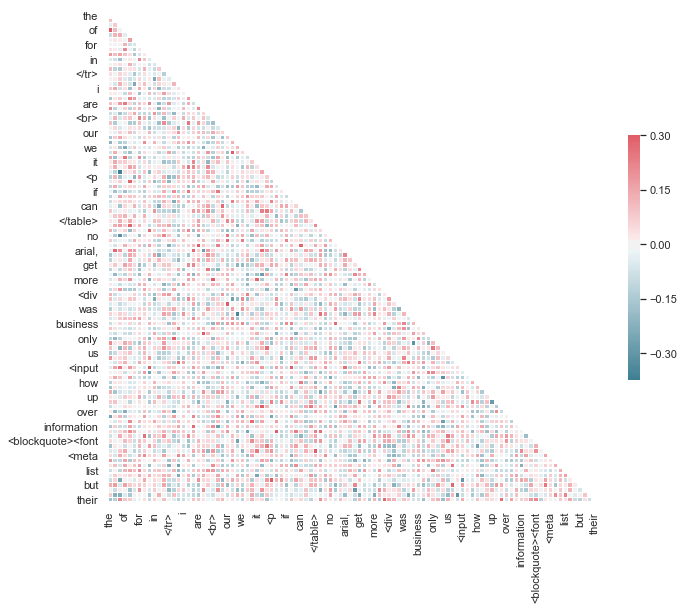

In [197]:
mytrain = train.copy()
sns.set(style='white')
rs = np.random.RandomState(33)
top100 = l[:100]
#top100 = pd.Series(top100_index)
d = pd.DataFrame(data=rs.normal(size=(100, 100)),
 columns=list(top100))
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

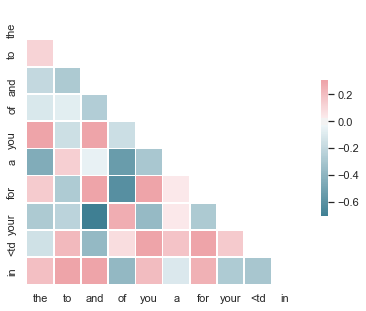

In [198]:
mytrain = train.copy()
sns.set(style='white')
rs = np.random.RandomState(33)
top100 = l[:10]
#top100 = pd.Series(top100_index)
d = pd.DataFrame(data=rs.normal(size=(10, 10)),
 columns=list(top100))
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

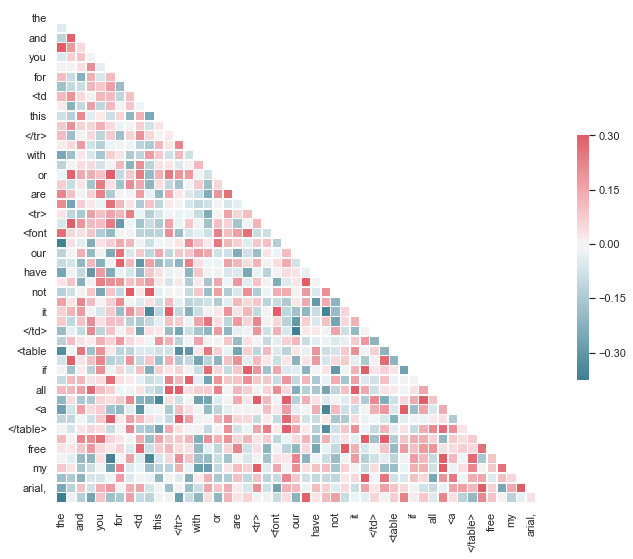

In [199]:
mytrain = train.copy()
sns.set(style='white')
rs = np.random.RandomState(33)
top100 = l[:50]
#top100 = pd.Series(top100_index)
d = pd.DataFrame(data=rs.normal(size=(50, 50)),
 columns=list(top100))
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Since it is not clear to use heatmap, we might attempt to use wordcloud for this case since it might reveal a better result

In [200]:
def re(data):
    data['reply'] = data['subject'].str.findall('Re:').str.len()
    return data

def select_columns(data, *columns):
     return data.loc[:, columns]
def find_forward(data):
    data['forward'] = data['subject'].str.findall('Fwd').str.len()
    return data
def num_less_than(data):
    data['num less than'] = data['email'].str.findall(r'<').str.len()
    return data

def lowercase(data):
    data['email01']= data['email']
    data['email01'] = data['email01'].str.lower()
    return data
def choose_words(data):
    some_words = ['bucks','4u','limited','call now','act now','purchase', 'as seen on', 'apply now','for only','opportunity','fees','refund','100%','sale',
'prize','free','td','dear',"urgent", "best", '<html>',"credit", "bank", "card""click", "request", "font",'debt', "face", "color", "br","3d", "body", "business", "money", "offer", "please"]
    lowercase(data)
    words = np.array(words_in_texts(some_words, data['email01']))
    data['word track'] = [sum(i) for i in words]
    return data

In [201]:
from sklearn.linear_model import LogisticRegression
def process_data_fm(data):
    data = (
    data
    # Clean Data
    .pipe(choose_words)
    #.pipe(remove_html)
    # Transform data
    .pipe(re)
    .pipe(find_forward)
    .pipe(find_exclamation)
    .pipe(number_of_punctuations)
    .pipe(num_less_than)
    .pipe(find_capital_letter_in_subject)
    .pipe(capital_letter_ratio)
    .pipe(select_columns,
    'spam',
    'num exclamation',
    'num punc',
    'num less than',
    'proportion_low',
    'reply',
    'word track',
    'forward',
    'proportion_low_sub'
        )
    )
    data = data.fillna(0)
    X = data.drop(['spam'], axis = 1)#.fillna(0)
    y = data['spam']
    return X, y
final_model = LogisticRegression()

x_train, y_train = process_data_fm(mytrain)
final_model.fit(x_train, y_train)
y_predicted_train = final_model.predict_proba(x_train)

train_accuracy = final_model.score(x_train, y_train)
train_accuracy

/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8999068281645148

0.8207107680021296


/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


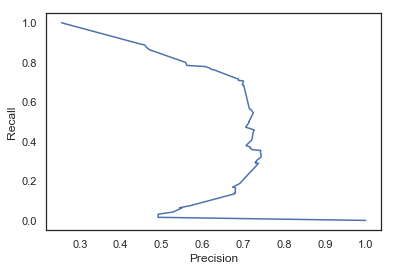

In [207]:
from sklearn.metrics import precision_recall_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

new_words = [ 'bucks','4u','limited','call now','act now','purchase', 'as seen on', 'apply now','for only','opportunity','fees','refund','100%','sale',
'prize','free','td','dear',"urgent", "best", '<html>',"credit", "bank", "card""click", "request", "font",'debt', "face", "color", "br","3d", "body", "business", "money", "offer", "please"]
        
new_train = words_in_texts(words, mytrain['email'])
new_model = LogisticRegression()
new_model.fit(new_train, Y_train)
accuracy = new_model.score(new_train, Y_train)
y_pred = new_model.predict_proba(new_train)[:,1]
curve = precision_recall_curve(Y_train, y_pred)
plt.plot(curve[0], curve[1])
plt.xlabel('Precision')
plt.ylabel('Recall')
print(accuracy);

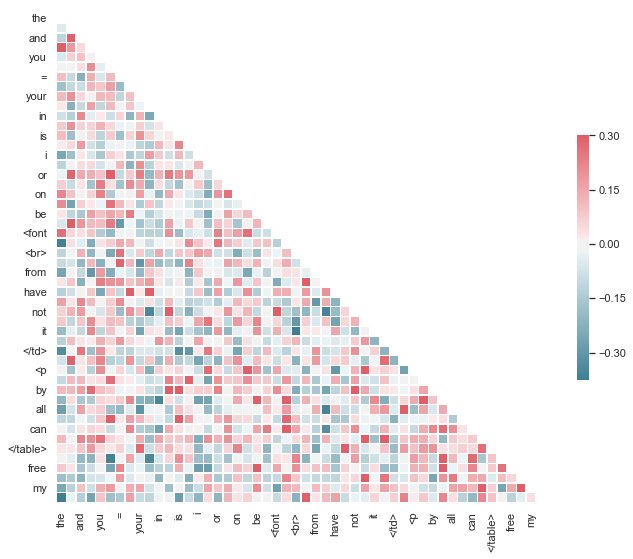

In [204]:
a = pd.Series(' '.join(original_training_data[original_training_data['spam'] == 1]['email']).lower().split()).value_counts()[:100]
pd.Series(a.index)

mytrain = train.copy()
sns.set(style='white')
rs = np.random.RandomState(33)
top100_index = pd.Series(' '.join(mytrain[mytrain['spam'] == 1]['email']).lower().split()).value_counts()[:50]
top100 = pd.Series(top100_index)
d = pd.DataFrame(data=rs.normal(size=(50, 50)),
 columns=list(top100.keys()))
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

0.8207107680021296


/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


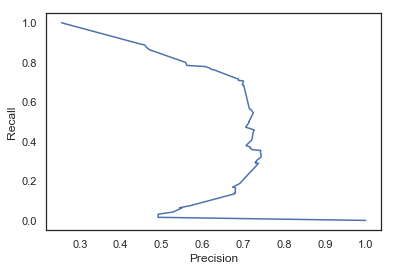

In [210]:
from sklearn.metrics import precision_recall_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

new_words = [ '<td', 'this','td','font','face','size', 'that', 'with','the','to','and','of','subscribed','money', 'contact',
         'for', 'your', 'i', 'are', 'be', '<tr>', '<br>', '<font', 'will', 'our', 'from', 'have', 'we',
         'not', '<a', 'helvetica', 'arial,', 'free', 'email', '<p', 'all', 'click',
         'font', 'face', 'remove', 'html', 'base64', 'body', '<table']
        
new_train = words_in_texts(words, train['email'])
new_model = LogisticRegression()
new_model.fit(new_train, Y_train)
accuracy = new_model.score(new_train, Y_train)
y_pred = new_model.predict_proba(new_train)[:,1]
curve = precision_recall_curve(Y_train, y_pred)
plt.plot(curve[0], curve[1])
plt.xlabel('Precision')
plt.ylabel('Recall')
print(accuracy)

    100% |████████████████████████████████| 163kB 2.9MB/s 


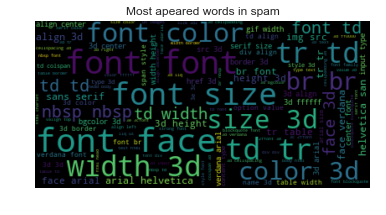

In [209]:
!pip install WordCloud
from os import path
from wordcloud import WordCloud
spam_email = train[train['spam'] == 1]['email']
wordcloud = WordCloud().generate(' '.join(spam_email))
wordcloud = WordCloud(max_font_size=40).generate(' '.join(spam_email))
plt.figure()
plt.title('Most apeared words in spam')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Summary: 
    - Use seaborn heatmap does not return clear solution. In case for word clasifying, using wordcloud is the better option.
    - Spam emails have different characters and words than regular personal email
    - Using a threshold, we can effectively classify spam emails from regular emails. 